In [2]:
import numpy as np
import scipy.stats as sts
import requests
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series
import heapq

In [3]:
open('clms.txt', 'r')

claims = np.loadtxt('clms.txt')

In [4]:
maxclms=claims.max()
minclms=claims.min()
meanclms=claims.mean()
medianclms=np.median(claims)
stdclms=claims.std()
print('Claims-mean ', meanclms)
print('Claims-median ', medianclms)
print('Claims-max ', maxclms)
print('Claims-min ', minclms)
print('Claims-Std. Dev. ', stdclms)

Claims-mean  720.2779753272437
Claims-median  172.21
Claims-max  227967.25
Claims-min  0.01
Claims-Std. Dev.  3972.663756393663


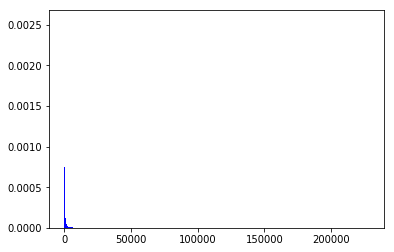

In [5]:
n, bins, patches=plt.hist(claims, 1000, density=1, facecolor='blue', alpha=5)

In [6]:
claims2 = []
i=0
while i <=len(claims)-1:
    if claims[i]<=800:
        claims2.append(claims[i])
        i+=1
    else:
        i+=1
len(claims2)


9020

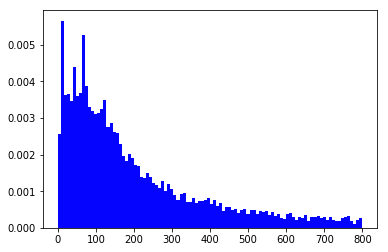

In [7]:
n, bins, patches=plt.hist(claims2, 100, density=1, facecolor='blue', alpha=5)

In [9]:
# generating values according to gamma dist.
import math as math
def gamma_pdf(x, a, b):
    pdf_val = x**(a-1)*np.exp(-x/b)/(math.gamma(a)*(b**a))
    return pdf_val

(0, 0.005)

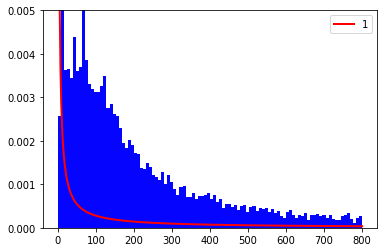

In [10]:
dist_pts = np.linspace(2**(-100), 800, 800)
b = stdclms**2/meanclms
a = meanclms / b
plt.plot(dist_pts, gamma_pdf(dist_pts, a, b),
         linewidth=2, color='r', label='1')
plt.legend(loc='upper right')

n, bins, patches=plt.hist(claims2, 100, density=1, facecolor='blue', alpha=5)
#plt.xlim(0,5000)
plt.ylim(0,0.005)

In [11]:
def log_lik_gamma(x, alpha, beta):
    pdf_value = gamma_pdf(x, alpha, beta)
    log_pdf_val = np.log(pdf_value)
    log_lik_val = log_pdf_val.sum()
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val

In [12]:
def criteria(params, args):
    alpha, beta = params
    x = args
    llval = log_lik_gamma(x, alpha, beta)
    return llval

In [13]:
import scipy.optimize as opt
a_in = a
b_in = b
par_in = np.array([a_in, b_in])
mle_arg = claims
results_uncstr = opt.minimize(criteria, par_in, mle_arg, method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
#print(results_uncstr)
a_MLE, b_MLE = results_uncstr.x
print('alpha MLE: ',a_MLE)
print('beta MLE: ',b_MLE)
print('Log Likelihood: ',log_lik_gamma(claims, a_MLE, b_MLE))

alpha MLE:  0.22175531695829706
beta MLE:  21911.06469926253
Log Likelihood:  82076.45160566375


(0, 0.005)

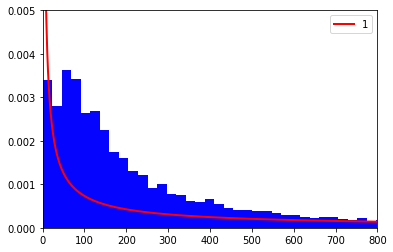

In [14]:
dist_pts = np.linspace(2**(-100), 800, 800)
b = b_MLE 
a = a_MLE 
plt.plot(dist_pts, gamma_pdf(dist_pts, a, b),
         linewidth=2, color='r', label='1')
plt.legend(loc='upper right')

n, bins, patches=plt.hist(claims, 10000, density=1, facecolor='blue', alpha=5)
plt.xlim(0,800)
plt.ylim(0,0.005)

In [15]:
def gammaGG_pdf(x, a, b, m):
    pdf_val = m*x**(a-1)*((np.exp(-x/b))**m)/(math.gamma(a/m)*(b**a))
    return pdf_val

In [16]:
def log_lik_gammaGG(x, alpha, beta, m):
    pdf_value = gammaGG_pdf(x, alpha, beta, m)
    log_pdf_val = np.log(pdf_value)
    log_likGG_val = log_pdf_val.sum()
    neg_log_likGG_val = -log_likGG_val
    return neg_log_likGG_val

In [17]:
def criteriaGG(params, args):
    alpha, beta, m = params
    x = args
    llval = log_lik_gammaGG(x, alpha, beta, m)
    return llval

In [18]:
b_in = stdclms**2/meanclms
a_in = meanclms / b_in
m_in = 1.0
par_in_GG = np.array([a_in, b_in, m_in])
mle_arg_GG = claims
results_uncstrGG = opt.minimize(criteriaGG, par_in_GG, args=(mle_arg_GG), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None), (1e-2, None)))
#print(results_uncstrGG)
a_GG_MLE, b_GG_MLE, m_GG_MLE = results_uncstrGG.x
print('alpha G. Gamma, MLE: ',a_GG_MLE)
print('beta G. Gamma, MLE: ',b_GG_MLE)
print('m G. Gamma, MLE: ',m_GG_MLE)
#print(log_lik_gammaGG(claims, a_GG_MLE, b_GG_MLE, m_GG_MLE))

alpha G. Gamma, MLE:  0.20668759109766532
beta G. Gamma, MLE:  21911.06469227428
m G. Gamma, MLE:  0.42083837635445687


(0, 0.005)

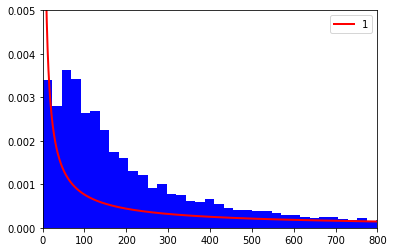

In [19]:
dist_pts = np.linspace(2**(-100), 800, 800)
b = b_GG_MLE 
a = a_GG_MLE
m = m_GG_MLE
plt.plot(dist_pts, gammaGG_pdf(dist_pts, a, b, m),
         linewidth=2, color='r', label='1')
plt.legend(loc='upper right')

n, bins, patches=plt.hist(claims, 10000, density=1, facecolor='blue', alpha=5)
plt.xlim(0,800)
plt.ylim(0,0.005)

In [20]:
def Beta(p,q):
    betafn=math.gamma(p)*math.gamma(q)/math.gamma(p+q)
    return betafn

def GB2_pdf(x, a, b, p, q):
    pdf_val = a*x**(a*p-1)/(b**(a*p)*Beta(p,q)*(1+(x/b)**a)**(p+q))#beta.pdf(x, a, b, p, q)
    return pdf_val

In [21]:
def log_lik_GB2(x, a, b, p, q):
    pdf_value = GB2_pdf(x, a, b, p, q)
    log_pdf_val = np.log(pdf_value)
    log_likGG_val = log_pdf_val.sum()
    neg_log_likGG_val = -log_likGG_val
    return neg_log_likGG_val

In [22]:
def criteriaGB2(params, args):
    a, b, p, q = params
    x = args
    llval = log_lik_GB2(x, a, b, p, q)
    return llval

In [23]:
b_in = stdclms**2/meanclms # if b is lower, then better fit
a_in = meanclms / b_in
p_in = 1.0
q_in = 100
par_in_GB2 = np.array([a_in, b_in, p_in, q_in])
mle_arg_GB2 = claims
results_uncstrGB2 = opt.minimize(criteriaGB2, par_in_GB2, args=(mle_arg_GB2), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None), (1e-2, None), (1e-2, 94)))
#print(results_uncstrGB2)
a_GB2_MLE, b_GB2_MLE, p_GB2_MLE, q_GB2_MLE = results_uncstrGB2.x
print('alpha GB2, MLE: ',a_GB2_MLE)
print('beta GB2, MLE: ',b_GB2_MLE)
print('p GB2, MLE: ',p_GB2_MLE)
print('q GB2, MLE: ',q_GB2_MLE)

alpha GB2, MLE:  0.11318587215953113
beta GB2, MLE:  21490.24184551854
p GB2, MLE:  55.10433877878896
q GB2, MLE:  94.0


(0, 0.005)

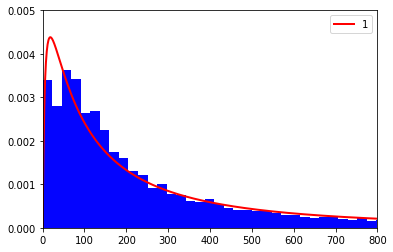

In [24]:
dist_pts = np.linspace(2**(-100), 800, 800)
b = b_GB2_MLE 
a = a_GB2_MLE
p = p_GB2_MLE
q = q_GB2_MLE
plt.plot(dist_pts, GB2_pdf(dist_pts, a, b, p, q),
         linewidth=2, color='r', label='1')
plt.legend(loc='upper right')

n, bins, patches=plt.hist(claims, 10000, density=1, facecolor='blue', alpha=5)
plt.xlim(0,800)
plt.ylim(0,0.005)

In [25]:
#Likelihood ratio test
a_GA = a_MLE
b_GA = b_MLE
a_GG = a_GG_MLE
b_GG = b_GG_MLE
m_GG = m_GG_MLE
a_GB2 = a_GB2_MLE
b_GB2 = b_GB2_MLE
p_GB2 = p_GB2_MLE
q_GB2 = q_GB2_MLE

log_likGA_MLE = log_lik_gamma(claims, a_GA, b_GA)
log_likGG_MLE = log_lik_gammaGG(claims, a_GG, b_GG, m_GG)
log_likGB2_MLE = log_lik_GB2(claims, a_GB2, b_GB2, p_GB2, q_GB2)

Lik_ratio1 = 2*(log_likGB2_MLE-log_likGA_MLE)
pvalue_GA = 1.0 - sts.chi2.cdf(Lik_ratio1, 4)

Lik_ratio2 = 2*(log_likGB2_MLE-log_likGG_MLE)
pvalue_GG = 1.0 - sts.chi2.cdf(Lik_ratio2, 4)

print('chi squared of GA with 4 degrees of freedom p-value = ', pvalue_GA)
print('chi squared of GG with 4 degrees of freedom p-value = ', pvalue_GG)

chi squared of GA with 4 degrees of freedom p-value =  1.0
chi squared of GG with 4 degrees of freedom p-value =  1.0


In [26]:
# Using the estimated GB2 distribution from part (d), how likely am I
# to have a monthly health care claim of more than $1,000? How does this 
# amount change if I use the estimated GA distribution from part (b)?

import scipy.integrate as integrate
import scipy.special as special

probGB2_0_1000=integrate.quad(lambda x: GB2_pdf(x,a_GB2, b_GB2, p_GB2, q_GB2),1e-10,1000)
print('The probability of having a claim over $1,000 is ', 1-probGB2_0_1000[0],'using estimated GB2 parameters')

probGA_0_1000=integrate.quad(lambda x: gamma_pdf(x,a_GA, b_GA),1e-10,1000)
print('The probability of having a claim over $1,000 is ', 1-probGA_0_1000[0],'using estimated GA parameters')


The probability of having a claim over $1,000 is  0.13083807040641116 using estimated GB2 parameters
The probability of having a claim over $1,000 is  0.4519597354517654 using estimated GA parameters


In [1169]:
#Question 2

In [27]:
ct=[]
kt=[]
wt=[]
rt=[]
with open("MacroSeries.txt", "r") as filestream:
    for line in filestream:
        c, k, w, r = map(float,line.split(','))
        ct.append(c)
        kt.append(k)
        wt.append(w)
        rt.append(r)

In [28]:
Ct=np.asarray(ct)
Kt=np.asarray(kt)
Wt=np.asarray(wt)
Rt=np.asarray(rt)

In [29]:
def eq3(w, k, a):
    value_z_est = np.log(w/((1-a)*(k**a)))
    return value_z_est

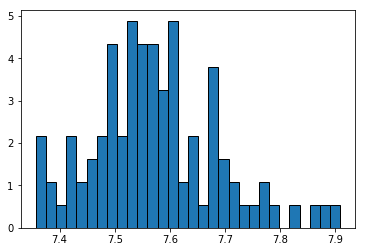

In [30]:
num_bins = 30
count, bins, ignored = plt.hist(eq3(Wt, Kt, 0.6), num_bins, density=True,
                                edgecolor='k')

In [31]:
def normal_pdf(val, mu, sigma, ro):
    mu2 = []
    i=0
    while i <= len(val)-1:
        if i==0:
            mu2.append(mu)
            i+=1
        else:
            mu2.append(ro*val[i-1]+(1-ro)*mu)
            i+=1
    mu2_a=np.asarray(mu2)
    normal_pdf_value = ((1/(sigma * np.sqrt(2 * np.pi)))*np.exp( - (val - mu2_a)**2 / (2 * sigma**2)))
    return normal_pdf_value

In [32]:
def log_lik_normal(val, mu, sigma, ro):
    pdf_value = normal_pdf(val, mu, sigma, ro)
    log_pdf_val = np.log(pdf_value)
    log_lik_val = log_pdf_val.sum()
    neg_log_lik_val = -log_lik_val
    return neg_log_lik_val

In [33]:
def criteria_normal(params, *args):
    mu, sigma, alpha, ro = params
    w, k = args
    z_vals = eq3(w, k, alpha)
    llval = log_lik_normal(z_vals, mu, sigma, ro)
    return llval

In [34]:
#optimizer
alpha_in = 0.5
ro_in = 0
mu_in = eq3(Wt, Kt, alpha_in).mean()
sigma_in = eq3(Wt, Kt, alpha_in).std()**2

par_in = np.array([mu_in, sigma_in, alpha_in, ro_in])

mle_args = (Wt, Kt)
results_uncstr = opt.minimize(criteria_normal, par_in, args=(mle_args), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None), (1e-10, 1-1e-10), (1e-10-1, 1-1e-10)))
#print(results_uncstr)
mu_1_MLE, sigma_1_MLE, alpha_1_MLE, ro_1_MLE = results_uncstr.x
print('mu: ',mu_1_MLE)
print('sigma: ',sigma_1_MLE)
print('alpha: ',alpha_1_MLE)
print('ro: ',ro_1_MLE)
print('Log Likelihood: ',log_lik_normal(eq3(Wt, Kt, alpha_1_MLE), mu_1_MLE, sigma_1_MLE, ro_1_MLE))
print('Hess. Inv.: ',results_uncstr.hess_inv)

C:\Users\Daniela\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


mu:  8.922016840470683
sigma:  0.3362982415211995
alpha:  0.47979426214000437
ro:  0.0656096381685017
Log Likelihood:  21.624481681092703
Hess. Inv.:  <4x4 LbfgsInvHessProduct with dtype=float64>


C:\Users\Daniela\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [36]:
def eq4(r, k, a):
    value_z4_est = np.log(r/(a*(k**(1-a))))
    return value_z4_est

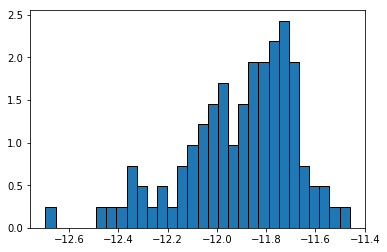

In [37]:
num_bins = 30
count, bins, ignored = plt.hist(eq4(Rt, Kt, 0.1), num_bins, density=True,
                                edgecolor='k')

In [38]:
def criteria_normalv2(params, *args):
    mu, sigma, alpha, ro = params
    r, k = args
    z4_vals = eq4(r, k, alpha)
    llval = log_lik_normal(z4_vals, mu, sigma, ro)
    return llval

In [ ]:
mu_in = eq4(Rt, Kt, 0.5).mean()
print(Rt.mean())


In [42]:
#optimizer
alpha_in = 0.5
ro_in = 0
mu_in = eq4(Rt, Kt, alpha_in).mean()
sigma_in = eq4(Rt, Kt, alpha_in).std()**2

par_in = np.array([mu_in, sigma_in, alpha_in, ro_in])

mle_args = (Rt, Kt)
results_uncstr = opt.minimize(criteria_normalv2, par_in, args=(mle_args), method='L-BFGS-B', bounds=((None, None), (1e-10, None), (1e-10, 1-1e-10), (1e-10-1, 1-1e-10)))
#print(results_uncstr)
mu_MLE, sigma_MLE, alpha_MLE, ro_MLE = results_uncstr.x
print('mu: ',mu_MLE)
print('sigma: ',sigma_MLE)
print('alpha: ',alpha_MLE)
print('ro: ',ro_MLE)
print('Log Likelihood: ',log_lik_normal(eq4(Rt, Kt, alpha_MLE), mu_MLE, sigma_MLE, ro_MLE))
print('Hess Inv: ',results_uncstr.hess_inv)

mu:  -7.19726196811359
sigma:  0.6049762418662346
alpha:  0.5216257623216793
ro:  0.01071173968495022
Log Likelihood:  56.894625684980014
Hess Inv:  <4x4 LbfgsInvHessProduct with dtype=float64>


C:\Users\Daniela\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [43]:
#part 2c

z_r1 = eq4(1, 7500000, alpha_1_MLE)
#print(z_r1)
#print(mu_1_MLE)
#print(sigma_1_MLE)
#print(ro_1_MLE)

In [44]:
def normal_pdf_2(val, mu, sigma, ro):
    normal_pdf_value = ((1/(sigma * np.sqrt(2 * np.pi)))*np.exp( - (val - mu)**2 / (2 * sigma**2)))
    return normal_pdf_value

In [1301]:
prob_normal_zr1=integrate.quad(lambda x: normal_pdf_2(x, mu_1_MLE, sigma_1_MLE, ro_1_MLE), -np.inf, z_r1)
print('The probability that the interest rate of period t will be greater than 1 is ', 1-prob_normal_zr1[0])

The probability that the interest rate of period t will be greater than 1 is  1.0
